In [1]:
import pyproj
import pandas as pd
import networkx as nx
import momepy as mpy
import geopandas as gpd

import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely import Point
from langchain_neo4j import Neo4jGraph


In [2]:
geod = pyproj.Geod(ellps="WGS84")

In [54]:
street = gpd.read_file("纽约.geojson")
street.head()

,OBJECTID,Id,Shape_Leng,geometry
0,1.0,0,83.486517,"LINESTRING (-8236976.888 4975171.983, -8236974..."
1,1.0,0,83.486517,"LINESTRING (-8236974.943 4975171.617, -8236960..."
2,1.0,0,83.486517,"LINESTRING (-8236960.748 4975163.62, -8236946...."
3,1.0,0,83.486517,"LINESTRING (-8236946.552 4975155.624, -8236932..."
4,1.0,0,83.486517,"LINESTRING (-8236932.356 4975147.627, -8236918..."


In [55]:
points = pd.read_csv("NewYork_8_info.csv")
geometry = [Point(xy) for xy in zip(points['lon'], points['lat'])]
points = gpd.GeoDataFrame(points, geometry=geometry, crs='EPSG:4326')
points.to_crs(street.crs, inplace=True)
points.head()

,filename,lon,lat,status,year,month,heading,walkable_headings,geometry
0,00000004.jpg,-73.993750,40.747409,1,2024,9,118.458954,"[118.0131149291992, 298.9031677246094]",POINT (-8236946.552 4975155.624)
1,00000002.jpg,-73.994005,40.747518,1,2024,9,121.997795,"[118.9078521728516, 298.9118347167969]",POINT (-8236974.943 4975171.617)
2,00000001.jpg,-73.994022,40.747520,1,2024,9,121.997795,"[118.9078521728516, 298.9118347167969]",POINT (-8236976.889 4975171.982)
3,00000003.jpg,-73.993877,40.747463,1,2024,9,118.392349,"[118.9031677246094, 298.9152221679688]",POINT (-8236960.747 4975163.62)
4,00000005.jpg,-73.993622,40.747354,1,2024,9,117.619728,"[117.9609375, 298.0131225585938]",POINT (-8236932.356 4975147.627)


In [56]:
graph = mpy.gdf_to_nx(street, approach="primal", multigraph=False, directed=False)

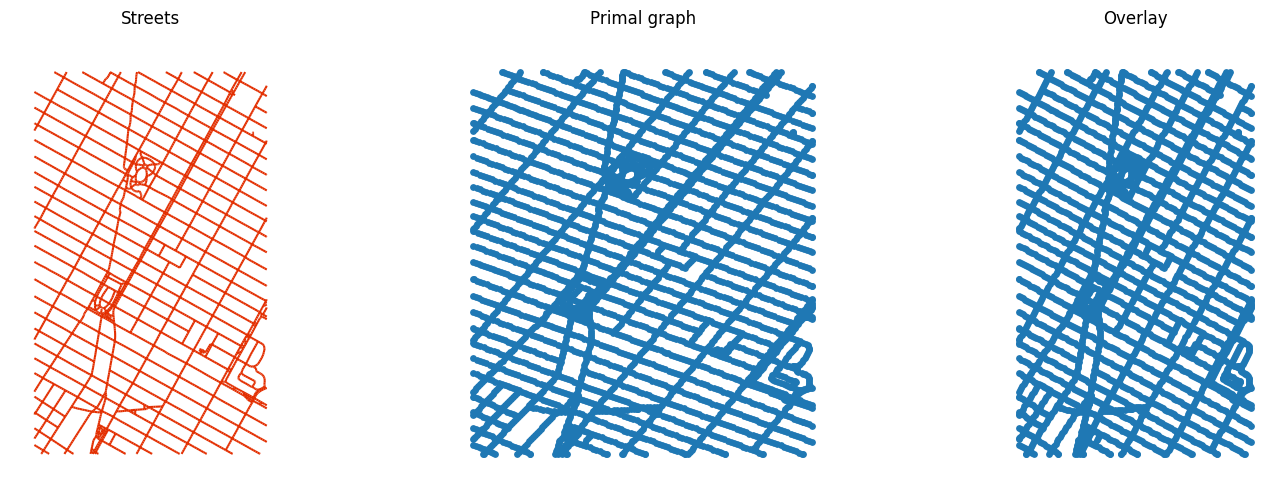

In [57]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
street.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=15
)
street.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15
)

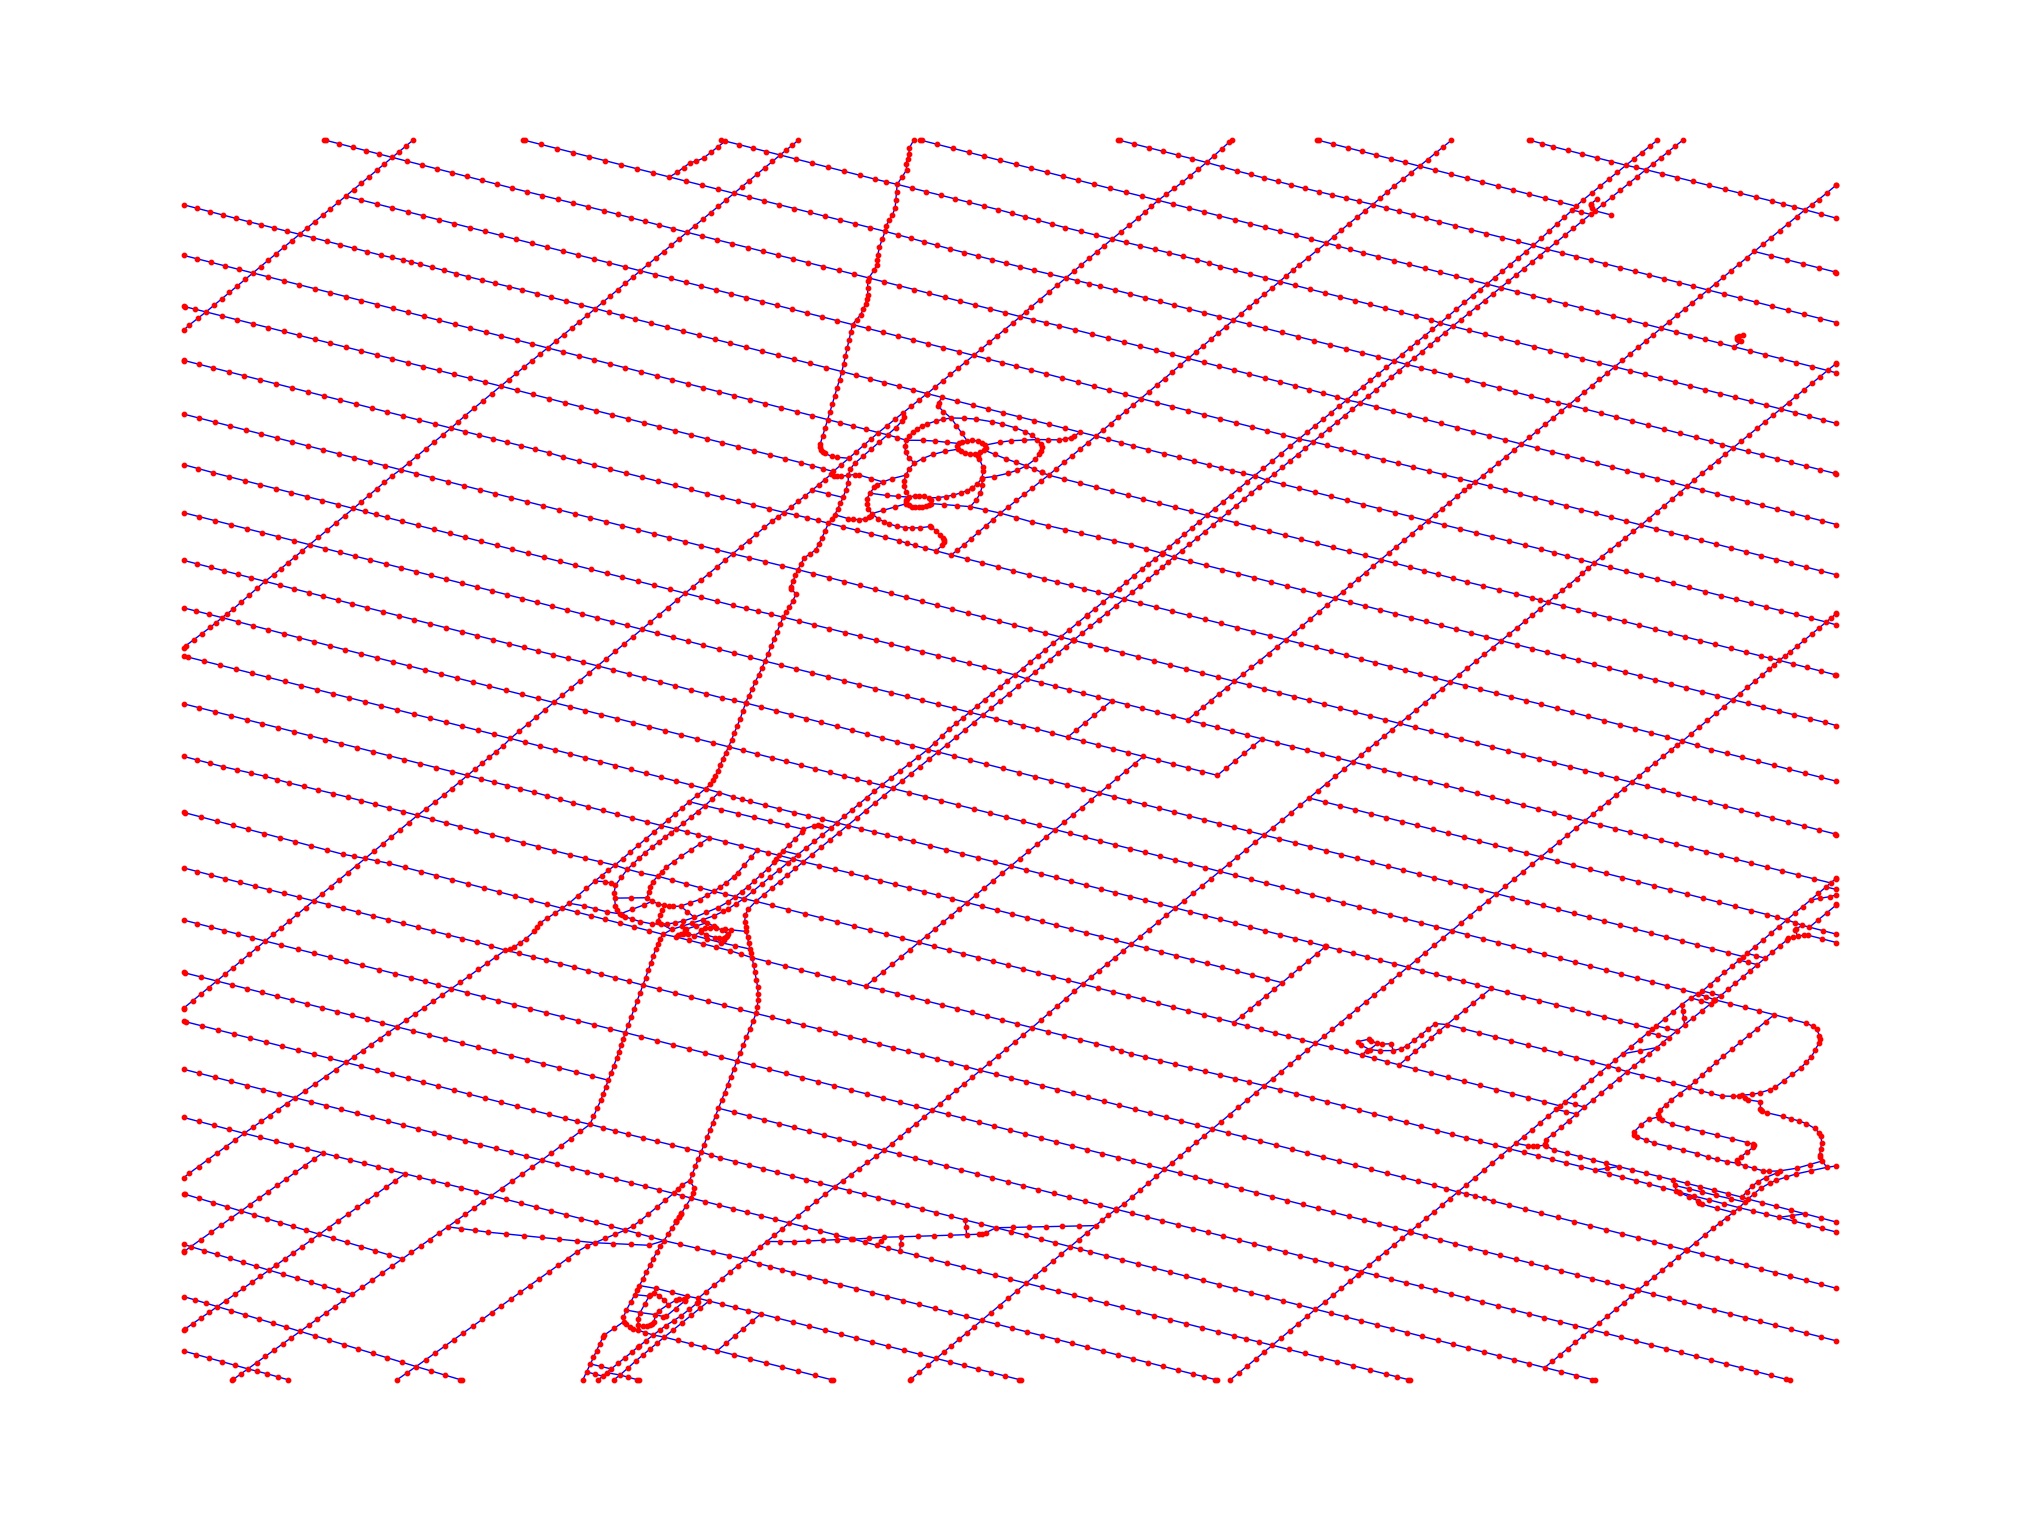

In [58]:
plt.figure(figsize=(20, 15))
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, node_size=10,node_color="red", edge_color="blue"
)

In [59]:
client = Neo4jGraph(
            url="bolt://localhost:7687",
            username="neo4j",
            password="bitnami1",
            database="newyork8" # replace with your database
        )

In [ ]:
client.query(f"CALL spatial.addPointLayer('locations')")

In [60]:
def get_closet_point(point: Point) -> gpd.GeoSeries:
    points["distance"] = points["geometry"].distance(point)

    return points.loc[points["distance"].idxmin()]

def create_node(point: gpd.GeoSeries):
    query_create_point = f"""
        MERGE (p1:Point {{filename: '{point["filename"]}', longitude: {point["lon"]}, latitude: {point["lat"]}, year: {point["year"]}, month: {point["month"]}, heading: {point["heading"]}, walkable_headings: {point["walkable_headings"]}}})
        WITH p1
        CALL spatial.addNode('locations', p1) YIELD node
        RETURN node
    """
    client.query(query_create_point)

def create_edges(point1: gpd.GeoSeries, point2: gpd.GeoSeries):
    distance = point1.geometry.distance(point2.geometry)
    lon1, lat1, lon2, lat2 = point1["lon"], point1["lat"], point2["lon"], point2["lat"]
    p1_to_p2_degree, p2_to_p1_degree, _ = geod.inv(lon1, lat1, lon2 ,lat2)
    if p1_to_p2_degree < 0:
        p1_to_p2_degree += 360
    if p2_to_p1_degree < 0:
        p2_to_p1_degree += 360
    query_create_relationship = f"""
        MATCH (p1:Point {{filename: '{point1["filename"]}'}}), (p2:Point {{filename: '{point2["filename"]}'}})
        MERGE (p1)-[r1:CONNECTED_TO]->(p2)
        SET r1.distance = {distance}, r1.azimuth = {p1_to_p2_degree}
        MERGE (p2)-[r2:CONNECTED_TO]->(p1)
        SET r2.distance = {distance}, r2.azimuth = {p2_to_p1_degree}
    """
    client.query(query_create_relationship)

In [61]:
# for node in tqdm(list(graph.nodes)):
#     point = Point(node)
#     closet_point = get_closet_point(point)
#     create_node(closet_point)

for edge in tqdm(list(graph.edges)):
    node1, node2 = edge
    closet_point1, closet_point2 = get_closet_point(Point(node1)), get_closet_point(Point(node2))
    create_edges(closet_point1, closet_point2)

100%|██████████| 4759/4759 [02:21<00:00, 33.74it/s]
